In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Toyota.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Auris,Seri_Avensis,Seri_Camry,...,Model_2.0 Sol Extra,Model_2.0 XL,Model_2.2 GL,Model_3.0 GX,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,575000,2017,99,1329,88000,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,195000,2008,90,1364,270148,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,764900,2015,132,1598,83000,0.0,1.0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,904000,2020,132,1598,22930,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,585000,2015,99,1329,230000,4.0,0.0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_2820\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,45287.121084,2.527887e+09,50278.101097,33047.729863


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-10-08 14:25:06,952] A new study created in memory with name: no-name-893911d4-0c12-4b7c-baba-b77ad301f6a1
[I 2023-10-08 14:25:07,239] Trial 6 finished with value: 487890.84977121255 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.006681455533781571, 'max_depth': 13, 'min_child_weight': 281}. Best is trial 6 with value: 487890.84977121255.
[I 2023-10-08 14:25:07,259] Trial 3 finished with value: 515186.0885424329 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.0008199402454615158, 'max_depth': 6, 'min_child_weight': 248}. Best is trial 6 with value: 487890.84977121255.
[I 2023-10-08 14:25:07,263] Trial 1 finished with value: 482459.00293085485 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.007815592417262547, 'max_depth': 4, 'min_child_weight': 35}. Best is trial 1 with value: 482459.00293085485.
[I 2023-10-08 14:25:07,265] Trial 5 finished with value: 513031.22956007527 and parameters:

[I 2023-10-08 14:25:08,566] Trial 30 finished with value: 220867.21719042116 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.09043279771210816, 'max_depth': 9, 'min_child_weight': 141}. Best is trial 24 with value: 63504.331935895636.
[I 2023-10-08 14:25:08,599] Trial 31 finished with value: 252340.45418268733 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.07468025171536175, 'max_depth': 9, 'min_child_weight': 67}. Best is trial 24 with value: 63504.331935895636.
[I 2023-10-08 14:25:08,725] Trial 32 finished with value: 218555.87873969303 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.09122978696497132, 'max_depth': 9, 'min_child_weight': 134}. Best is trial 24 with value: 63504.331935895636.
[I 2023-10-08 14:25:08,765] Trial 33 finished with value: 147360.37369262343 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.13309487409952153, 'max_depth': 9, 'min_child_w

[I 2023-10-08 14:25:10,343] Trial 60 finished with value: 138153.55570028294 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.135735486815739, 'max_depth': 5, 'min_child_weight': 44}. Best is trial 53 with value: 61507.16530555572.
[I 2023-10-08 14:25:10,407] Trial 63 finished with value: 118099.31467508507 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.16198214725083376, 'max_depth': 4, 'min_child_weight': 37}. Best is trial 53 with value: 61507.16530555572.
[I 2023-10-08 14:25:10,423] Trial 61 finished with value: 149164.6189057204 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.1291901031018394, 'max_depth': 4, 'min_child_weight': 237}. Best is trial 53 with value: 61507.16530555572.
[I 2023-10-08 14:25:10,434] Trial 62 finished with value: 127048.21563182633 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.14851440327024798, 'max_depth': 4, 'min_child_weight': 

[I 2023-10-08 14:25:12,147] Trial 89 finished with value: 52567.564580614286 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4988174543908997, 'max_depth': 7, 'min_child_weight': 68}. Best is trial 89 with value: 52567.564580614286.
[I 2023-10-08 14:25:12,322] Trial 91 finished with value: 91558.71148099873 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.18421370477613974, 'max_depth': 7, 'min_child_weight': 59}. Best is trial 89 with value: 52567.564580614286.
[I 2023-10-08 14:25:12,424] Trial 92 finished with value: 105429.05721783167 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.16614673356816953, 'max_depth': 8, 'min_child_weight': 59}. Best is trial 89 with value: 52567.564580614286.
[I 2023-10-08 14:25:12,452] Trial 93 finished with value: 94273.22969394982 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.18020443518305362, 'max_depth': 8, 'min_child_weight

[I 2023-10-08 14:25:14,306] Trial 120 finished with value: 53800.33095554579 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4202853735684112, 'max_depth': 7, 'min_child_weight': 78}. Best is trial 89 with value: 52567.564580614286.
[I 2023-10-08 14:25:14,339] Trial 121 finished with value: 55299.87653100739 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.33658251594509037, 'max_depth': 7, 'min_child_weight': 76}. Best is trial 89 with value: 52567.564580614286.
[I 2023-10-08 14:25:14,385] Trial 122 finished with value: 55927.55634000642 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3278225378109729, 'max_depth': 5, 'min_child_weight': 74}. Best is trial 89 with value: 52567.564580614286.
[I 2023-10-08 14:25:14,385] Trial 123 finished with value: 56370.459167432884 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.32024651413269695, 'max_depth': 5, 'min_child_weig

[I 2023-10-08 14:25:16,464] Trial 150 finished with value: 50564.47791263135 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.37955908162153423, 'max_depth': 9, 'min_child_weight': 3}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:16,516] Trial 151 finished with value: 50562.11617917492 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.37208554447568964, 'max_depth': 10, 'min_child_weight': 3}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:16,673] Trial 152 finished with value: 52377.399167998316 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.37537457596508805, 'max_depth': 10, 'min_child_weight': 1}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:16,696] Trial 153 finished with value: 50387.41977414697 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3688332694620218, 'max_depth': 10, 'min_child_

[I 2023-10-08 14:25:18,819] Trial 180 finished with value: 52754.23856109553 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.3231167422166726, 'max_depth': 9, 'min_child_weight': 7}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:18,861] Trial 182 finished with value: 53391.84066095854 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.32362477863609523, 'max_depth': 9, 'min_child_weight': 8}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:18,881] Trial 181 finished with value: 455224.24399544514 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.013561760787640174, 'max_depth': 9, 'min_child_weight': 8}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:19,032] Trial 183 finished with value: 456910.7841393727 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.013182191565453168, 'max_depth': 9, 'min_child_w

[I 2023-10-08 14:25:21,121] Trial 209 finished with value: 51886.082008884965 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3265358745908364, 'max_depth': 10, 'min_child_weight': 6}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:21,176] Trial 212 finished with value: 52088.48600578552 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.32287642116580345, 'max_depth': 10, 'min_child_weight': 4}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:21,247] Trial 211 finished with value: 51942.08308929382 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.32479962719522176, 'max_depth': 10, 'min_child_weight': 4}. Best is trial 142 with value: 49906.069217292454.
[I 2023-10-08 14:25:21,339] Trial 213 finished with value: 53065.580417894525 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3190274063504209, 'max_depth': 10, 'min_child

[I 2023-10-08 14:25:23,817] Trial 241 finished with value: 58068.40231395192 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.26784227133432015, 'max_depth': 12, 'min_child_weight': 16}. Best is trial 226 with value: 49623.96057540074.
[I 2023-10-08 14:25:23,862] Trial 243 finished with value: 57907.69997363861 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.2691740380540923, 'max_depth': 12, 'min_child_weight': 16}. Best is trial 226 with value: 49623.96057540074.
[I 2023-10-08 14:25:23,900] Trial 246 finished with value: 55106.58286194 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.2843615149786994, 'max_depth': 12, 'min_child_weight': 16}. Best is trial 226 with value: 49623.96057540074.
[I 2023-10-08 14:25:23,901] Trial 244 finished with value: 55734.762730907576 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.28101355162227243, 'max_depth': 12, 'min_child_wei

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 49608.0499
Best params:
	colsample_bytree: 0.9
	subsample: 0.8
	learning_rate: 0.4374332570441805
	max_depth: 12
	min_child_weight: 17


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)


final_model = model.set_params(**study.best_params).fit(X_train,y_train)
    
cv_results = cross_validate(final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
    
y_pred = final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

{'TestDeger': 49481.998356873126, 'MSE': 2779309123.9475384, 'RMSE': 52719.15329315844, 'MAE': 36677.50684164839}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9319174749530497

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.924262945251542

In [16]:
marka_model = joblib.dump(final_model, "Toyota.pkl")

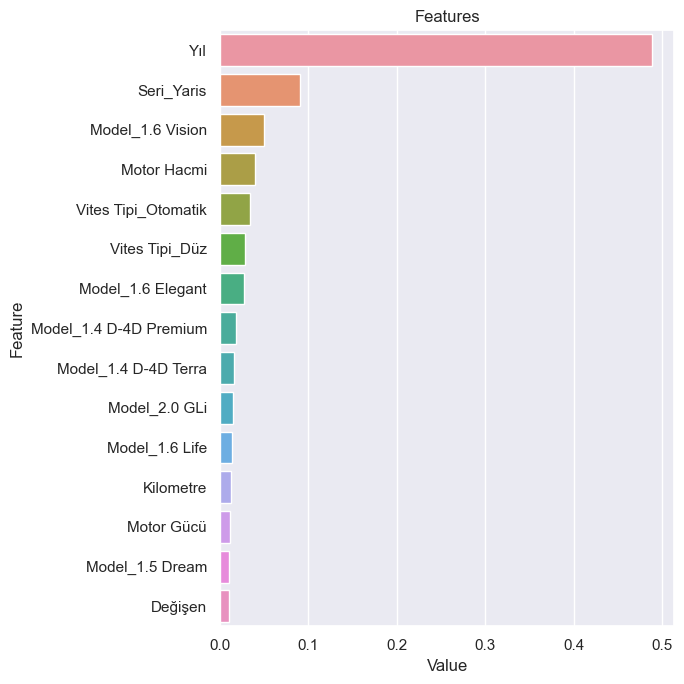

In [17]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(final_model,X)